In [1]:
#Librerías
import numpy as np
import pandas as pd
from pathlib import Path

from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

# oversampling en pipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import RandomOverSampler

# Métricas y gráficos
from sklearn.metrics import (
    roc_auc_score, roc_curve, precision_recall_curve,
    confusion_matrix, precision_score, recall_score,
    f1_score, accuracy_score
)
import matplotlib.pyplot as plt

# Configuración
RANDOM_STATE = 42
OUTPUTS = Path("../outputs")
TABLAS = OUTPUTS / "tablas"
FIGURAS = OUTPUTS / "figuras"
TABLAS.mkdir(parents=True, exist_ok=True)
FIGURAS.mkdir(parents=True, exist_ok=True)

# Esquema de validación (k=5 estratificado, sin fuga de información)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

print("Notebook 03 listo. CV estratificado k=5 configurado.")

Notebook 03 listo. CV estratificado k=5 configurado.


In [2]:
#Preprocesador

import pandas as pd
from pathlib import Path
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

# Rutas
DATA_PATH = Path("../data/stroke.csv")

# 1) Cargar datos
df = pd.read_csv(DATA_PATH)

# 2) Comprobaciones mínimas del objetivo
assert "stroke" in df.columns, "No se encuentra la columna 'stroke' en el CSV."
assert set(df["stroke"].unique()) <= {0,1}, "La variable 'stroke' debe ser binaria 0/1."

# 3) Separar X e y
y = df["stroke"].astype(int)
X = df.drop(columns=["stroke"])

# 4) Declarar columnas
num_cols = ["age", "avg_glucose_level", "bmi", "hypertension", "heart_disease"]
cat_cols = ["gender", "ever_married", "work_type", "Residence_type", "smoking_status"]

# Verificar existencia
missing_num = [c for c in num_cols if c not in X.columns]
missing_cat = [c for c in cat_cols if c not in X.columns]
assert not missing_num and not missing_cat, f"Faltan columnas -> num:{missing_num} | cat:{missing_cat}"

# 5) Definir transformadores
num_tf = Pipeline(steps=[
    ("imp", SimpleImputer(strategy="median")),
    ("sc", StandardScaler())
])

cat_tf = Pipeline(steps=[
    ("imp", SimpleImputer(strategy="most_frequent")),
    ("ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

# 6) ColumnTransformer (solo se define)
preprocessor = ColumnTransformer(
    transformers=[
        ("num", num_tf, num_cols),
        ("cat", cat_tf, cat_cols)
    ],
    remainder="drop",
    verbose_feature_names_out=False
)

print("Datos cargados:", df.shape)
print("X:", X.shape, "| y:", y.shape)
print("Numéricas:", num_cols)
print("Categóricas:", cat_cols)
print("Preprocesador listo (imputación + OHE + escalado).")

Datos cargados: (5110, 12)
X: (5110, 11) | y: (5110,)
Numéricas: ['age', 'avg_glucose_level', 'bmi', 'hypertension', 'heart_disease']
Categóricas: ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']
Preprocesador listo (imputación + OHE + escalado).


In [3]:
# Regresión logística

from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_predict

# Definir modelo y pipeline
clf_rl = LogisticRegression(
    max_iter=5000,
    class_weight="balanced",
    solver="lbfgs",
    random_state=RANDOM_STATE
)
pipe_rl = Pipeline(steps=[("prepro", preprocessor), ("clf", clf_rl)])

# Predicciones OOF (probabilidades)
proba_oof = cross_val_predict(pipe_rl, X, y, cv=cv, method="predict_proba")[:, 1]

# AUC y umbrales
auc_rl = roc_auc_score(y, proba_oof)

# Umbral 0.5
pred_05 = (proba_oof >= 0.5).astype(int)

# Umbral óptimo (Youden J = sensibilidad + especificidad - 1)
fpr, tpr, thr = roc_curve(y, proba_oof)
youden = tpr - (1 - fpr)
thr_opt = thr[youden.argmax()]
pred_opt = (proba_oof >= thr_opt).astype(int)

# Función de métricas clínicas
def metricas_binarias(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    sens = recall_score(y_true, y_pred)                     # sensibilidad
    esp  = tn / (tn + fp) if (tn + fp) > 0 else float("nan")# especificidad
    prec = precision_score(y_true, y_pred, zero_division=0) # precisión
    f1   = f1_score(y_true, y_pred)
    acc  = accuracy_score(y_true, y_pred)
    return {
        "accuracy": acc, "sensitivity": sens, "specificity": esp,
        "precision": prec, "f1": f1, "tn": tn, "fp": fp, "fn": fn, "tp": tp
    }

m_05  = metricas_binarias(y, pred_05)
m_opt = metricas_binarias(y, pred_opt)

# Guardar tablas
res_rl = pd.DataFrame([{
    "model": "RL", "strategy": "class_weight", "auc": auc_rl, "thr_opt": thr_opt,
    **{f"{k}_t05": v for k, v in m_05.items()},
    **{f"{k}_topt": v for k, v in m_opt.items()}
}])

# Guardar/Acumular resultados en CSV
out_csv = TABLAS / "resultados_RL_classweight_cv.csv"
res_rl.round(4).to_csv(out_csv, index=False)

# Guardar predicciones OOF por registro (útil para análisis posteriores)
pd.DataFrame({"proba_oof": proba_oof, "y": y}).to_csv(TABLAS / "oof_RL_classweight.csv", index=False)

print("AUC (OOF) RL-class_weight:", round(auc_rl, 4))
print("Umbral óptimo (Youden J):", round(thr_opt, 4))
print("Métricas t=0.5:", {k: round(v,4) for k,v in m_05.items() if k in ["sensitivity","specificity","precision","f1","accuracy"]})
print("Métricas t=opt:", {k: round(v,4) for k,v in m_opt.items() if k in ["sensitivity","specificity","precision","f1","accuracy"]})
print("Guardado CSV:", out_csv)

# Figuras: ROC, PR y Matrices de Confusión
# ROC
plt.figure()
plt.plot(fpr, tpr, label=f"RL-class_weight (AUC={auc_rl:.3f})")
plt.plot([0,1], [0,1], linestyle="--")
plt.xlabel("1 - Especificidad")
plt.ylabel("Sensibilidad")
plt.title("Curva ROC OOF - Regresión Logística [class_weight]")
plt.legend()
plt.tight_layout()
plt.savefig(FIGURAS / "ROC_RL_classweight.png", dpi=300)
plt.close()

# PR
prec, rec, _ = precision_recall_curve(y, proba_oof)
plt.figure()
plt.plot(rec, prec)
plt.xlabel("Recall (Sensibilidad)")
plt.ylabel("Precisión")
plt.title("Curva Precisión-Recall OOF - Regresión Logística [class_weight]")
plt.tight_layout()
plt.savefig(FIGURAS / "PR_RL_classweight.png", dpi=300)
plt.close()

# Matriz de confusión t=0.5
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions(y, pred_05, colorbar=False)
plt.title("Matriz de confusión (t=0.5) - RL [class_weight]")
plt.tight_layout()
plt.savefig(FIGURAS / "CM_05_RL_classweight.png", dpi=300)
plt.close()

# Matriz de confusión t=óptimo
ConfusionMatrixDisplay.from_predictions(y, pred_opt, colorbar=False)
plt.title(f"Matriz de confusión (t=óptimo={thr_opt:.3f}) - RL [class_weight]")
plt.tight_layout()
plt.savefig(FIGURAS / "CM_OPT_RL_classweight.png", dpi=300)
plt.close()

AUC (OOF) RL-class_weight: 0.8367
Umbral óptimo (Youden J): 0.0102
Métricas t=0.5: {'accuracy': 0.7397, 'sensitivity': 0.7952, 'specificity': 0.7369, 'precision': 0.1341, 'f1': 0.2294}
Métricas t=opt: {'accuracy': 0.0487, 'sensitivity': 1.0, 'specificity': 0.0, 'precision': 0.0487, 'f1': 0.0929}
Guardado CSV: ..\outputs\tablas\resultados_RL_classweight_cv.csv


In [4]:
# Correccion debido al valor Youden J): 0.0102
# en memoria: y, proba_oof, TABLAS, FIGURAS

# Recalcular ROC y umbral óptimo de Youden (CORRECTO)
fpr, tpr, thr = roc_curve(y, proba_oof)
youden = tpr - fpr                     # corrección
ix_opt = np.argmax(youden)
thr_opt = thr[ix_opt]
pred_opt = (proba_oof >= thr_opt).astype(int)

# Mantener t=0.5 
pred_05 = (proba_oof >= 0.5).astype(int)

def metricas_binarias(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    sens = recall_score(y_true, y_pred)                     # sensibilidad
    esp  = tn / (tn + fp) if (tn + fp) > 0 else float("nan")# especificidad
    prec = precision_score(y_true, y_pred, zero_division=0) # precisión
    f1   = f1_score(y_true, y_pred)
    acc  = accuracy_score(y_true, y_pred)
    return {
        "accuracy": acc, "sensitivity": sens, "specificity": esp,
        "precision": prec, "f1": f1, "tn": tn, "fp": fp, "fn": fn, "tp": tp
    }

auc_rl = roc_auc_score(y, proba_oof)
m_05  = metricas_binarias(y, pred_05)
m_opt = metricas_binarias(y, pred_opt)

# Umbral que maximiza F1 sobre OOF, para referencia clínica
prec, rec, thr_pr = precision_recall_curve(y, proba_oof)
f1_scores = 2*prec*rec/(prec+rec + 1e-12)
ix_f1 = np.nanargmax(f1_scores)
thr_f1 = thr_pr[ix_f1] if len(thr_pr) > 0 else 0.5
pred_f1 = (proba_oof >= thr_f1).astype(int)
m_f1 = metricas_binarias(y, pred_f1)

# Guardar 
res_rl = pd.DataFrame([{
    "model": "RL", "strategy": "class_weight", "auc": auc_rl,
    "thr_opt_youden": thr_opt, "thr_opt_f1": thr_f1,
    **{f"{k}_t05": v for k, v in m_05.items()},
    **{f"{k}_tyouden": v for k, v in m_opt.items()},
    **{f"{k}_tf1": v for k, v in m_f1.items()},
}])

out_csv = TABLAS / "resultados_RL_classweight_cv.csv"
res_rl.round(4).to_csv(out_csv, index=False)
print("AUC (OOF) RL:", round(auc_rl, 4))
print("Umbral óptimo Youden (corregido):", round(thr_opt, 4))
print("Umbral óptimo F1:", round(thr_f1, 4))
print("t=0.5:", {k: round(v,4) for k,v in m_05.items() if k in ["sensitivity","specificity","precision","f1","accuracy"]})
print("t=Youden:", {k: round(v,4) for k,v in m_opt.items() if k in ["sensitivity","specificity","precision","f1","accuracy"]})
print("t=F1:", {k: round(v,4) for k,v in m_f1.items() if k in ["sensitivity","specificity","precision","f1","accuracy"]})
print("Actualizado CSV:", out_csv)

# 5) Rehacer y guardar figuras con el Youden correcto
# ROC
plt.figure()
plt.plot(fpr, tpr, label=f"RL-class_weight (AUC={auc_rl:.3f})")
plt.plot([0,1], [0,1], linestyle="--")
plt.scatter(fpr[ix_opt], tpr[ix_opt], marker="o", label=f"Youden (thr={thr_opt:.3f})")
plt.xlabel("1 - Especificidad")
plt.ylabel("Sensibilidad")
plt.title("Curva ROC OOF - Regresión Logística [class_weight]")
plt.legend()
plt.tight_layout()
plt.savefig(FIGURAS / "ROC_RL_classweight.png", dpi=300)
plt.close()

# PR
plt.figure()
plt.plot(rec, prec)
plt.xlabel("Recall (Sensibilidad)")
plt.ylabel("Precisión")
plt.title("Curva Precisión-Recall OOF - Regresión Logística [class_weight]")
plt.tight_layout()
plt.savefig(FIGURAS / "PR_RL_classweight.png", dpi=300)
plt.close()

# Matrices de confusión
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions(y, pred_05, colorbar=False)
plt.title("Matriz de confusión (t=0.5) - RL [class_weight]")
plt.tight_layout()
plt.savefig(FIGURAS / "CM_05_RL_classweight.png", dpi=300)
plt.close()

ConfusionMatrixDisplay.from_predictions(y, pred_opt, colorbar=False)
plt.title(f"Matriz de confusión (t=Youden={thr_opt:.3f}) - RL [class_weight]")
plt.tight_layout()
plt.savefig(FIGURAS / "CM_YOUDEN_RL_classweight.png", dpi=300)
plt.close()

AUC (OOF) RL: 0.8367
Umbral óptimo Youden (corregido): 0.4432
Umbral óptimo F1: 0.7449
t=0.5: {'accuracy': 0.7397, 'sensitivity': 0.7952, 'specificity': 0.7369, 'precision': 0.1341, 'f1': 0.2294}
t=Youden: {'accuracy': 0.7068, 'sensitivity': 0.8554, 'specificity': 0.6992, 'precision': 0.1272, 'f1': 0.2214}
t=F1: {'accuracy': 0.8687, 'sensitivity': 0.5261, 'specificity': 0.8862, 'precision': 0.1915, 'f1': 0.2808}
Actualizado CSV: ..\outputs\tablas\resultados_RL_classweight_cv.csv


In [5]:
# Árbol de Decisión 

from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import (roc_auc_score, roc_curve, precision_recall_curve,
                             confusion_matrix, precision_score, recall_score,
                             f1_score, accuracy_score, ConfusionMatrixDisplay)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Modelo y pipeline
clf_dt = DecisionTreeClassifier(
    criterion="gini",
    class_weight="balanced",
    random_state=RANDOM_STATE
)
pipe_dt = Pipeline(steps=[("prepro", preprocessor), ("clf", clf_dt)])

# Predicciones OOF (probabilidades)
proba_oof = cross_val_predict(pipe_dt, X, y, cv=cv, method="predict_proba")[:, 1]

# AUC y umbrales
auc_dt = roc_auc_score(y, proba_oof)

# t=0.5
pred_05 = (proba_oof >= 0.5).astype(int)

# Youden  (J = tpr - fpr)
fpr, tpr, thr = roc_curve(y, proba_oof)
youden = tpr - fpr
ix_opt = np.argmax(youden)
thr_opt = thr[ix_opt]
pred_opt = (proba_oof >= thr_opt).astype(int)

# Umbral que maximiza F1 (referencia)
prec, rec, thr_pr = precision_recall_curve(y, proba_oof)
f1_scores = 2*prec*rec/(prec+rec + 1e-12)
ix_f1 = np.nanargmax(f1_scores)
thr_f1 = thr_pr[ix_f1] if len(thr_pr) > 0 else 0.5
pred_f1 = (proba_oof >= thr_f1).astype(int)

# Métricas clínicas
def metricas_binarias(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    sens = recall_score(y_true, y_pred)                      # sensibilidad
    esp  = tn / (tn + fp) if (tn + fp) > 0 else float("nan") # especificidad
    prec = precision_score(y_true, y_pred, zero_division=0)  # precisión
    f1   = f1_score(y_true, y_pred)
    acc  = accuracy_score(y_true, y_pred)
    return {"accuracy": acc, "sensitivity": sens, "specificity": esp,
            "precision": prec, "f1": f1, "tn": tn, "fp": fp, "fn": fn, "tp": tp}

m_05  = metricas_binarias(y, pred_05)
m_opt = metricas_binarias(y, pred_opt)
m_f1  = metricas_binarias(y, pred_f1)

# Guardar tablas
res_dt = pd.DataFrame([{
    "model": "DecisionTree", "strategy": "class_weight", "auc": auc_dt,
    "thr_opt_youden": thr_opt, "thr_opt_f1": thr_f1,
    **{f"{k}_t05": v for k, v in m_05.items()},
    **{f"{k}_tyouden": v for k, v in m_opt.items()},
    **{f"{k}_tf1": v for k, v in m_f1.items()},
}])

out_csv = TABLAS / "resultados_DT_classweight_cv.csv"
res_dt.round(4).to_csv(out_csv, index=False)

# Guardar predicciones OOF
pd.DataFrame({"proba_oof": proba_oof, "y": y}).to_csv(TABLAS / "oof_DT_classweight.csv", index=False)

print("AUC (OOF) DT-class_weight:", round(auc_dt, 4))
print("Umbral óptimo Youden:", round(thr_opt, 4))
print("Umbral óptimo F1:", round(thr_f1, 4))
print("t=0.5:",   {k: round(v,4) for k,v in m_05.items()  if k in ["sensitivity","specificity","precision","f1","accuracy"]})
print("t=Youden:",{k: round(v,4) for k,v in m_opt.items() if k in ["sensitivity","specificity","precision","f1","accuracy"]})
print("t=F1:",    {k: round(v,4) for k,v in m_f1.items()  if k in ["sensitivity","specificity","precision","f1","accuracy"]})
print("Guardado CSV:", out_csv)

# Figuras
# ROC
plt.figure()
plt.plot(fpr, tpr, label=f"DT-class_weight (AUC={auc_dt:.3f})")
plt.plot([0,1], [0,1], linestyle="--")
plt.scatter(fpr[ix_opt], tpr[ix_opt], marker="o", label=f"Youden (thr={thr_opt:.3f})")
plt.xlabel("1 - Especificidad")
plt.ylabel("Sensibilidad")
plt.title("Curva ROC OOF - Árbol de Decisión [class_weight]")
plt.legend()
plt.tight_layout()
plt.savefig(FIGURAS / "ROC_DT_classweight.png", dpi=300)
plt.close()

# PR
plt.figure()
plt.plot(rec, prec)
plt.xlabel("Recall (Sensibilidad)")
plt.ylabel("Precisión")
plt.title("Curva Precisión-Recall OOF - Árbol de Decisión [class_weight]")
plt.tight_layout()
plt.savefig(FIGURAS / "PR_DT_classweight.png", dpi=300)
plt.close()

# Matrices de confusión
ConfusionMatrixDisplay.from_predictions(y, pred_05, colorbar=False)
plt.title("Matriz de confusión (t=0.5) - DT [class_weight]")
plt.tight_layout()
plt.savefig(FIGURAS / "CM_05_DT_classweight.png", dpi=300)
plt.close()

ConfusionMatrixDisplay.from_predictions(y, pred_opt, colorbar=False)
plt.title(f"Matriz de confusión (t=Youden={thr_opt:.3f}) - DT [class_weight]")
plt.tight_layout()
plt.savefig(FIGURAS / "CM_YOUDEN_DT_classweight.png", dpi=300)
plt.close()

AUC (OOF) DT-class_weight: 0.5503
Umbral óptimo Youden: 1.0
Umbral óptimo F1: 1.0
t=0.5: {'accuracy': 0.9202, 'sensitivity': 0.1406, 'specificity': 0.9601, 'precision': 0.1528, 'f1': 0.1464}
t=Youden: {'accuracy': 0.9202, 'sensitivity': 0.1406, 'specificity': 0.9601, 'precision': 0.1528, 'f1': 0.1464}
t=F1: {'accuracy': 0.9202, 'sensitivity': 0.1406, 'specificity': 0.9601, 'precision': 0.1528, 'f1': 0.1464}
Guardado CSV: ..\outputs\tablas\resultados_DT_classweight_cv.csv


In [6]:
# Random Forest

from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import (roc_auc_score, roc_curve, precision_recall_curve,
                             confusion_matrix, precision_score, recall_score,
                             f1_score, accuracy_score, ConfusionMatrixDisplay)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Modelo y pipeline
clf_rf = RandomForestClassifier(
    n_estimators=500,
    max_depth=None,               
    min_samples_split=2,
    min_samples_leaf=1,
    n_jobs=-1,
    class_weight="balanced_subsample",
    random_state=RANDOM_STATE
)
pipe_rf = Pipeline(steps=[("prepro", preprocessor), ("clf", clf_rf)])

# Predicciones OOF (probabilidades)
proba_oof = cross_val_predict(pipe_rf, X, y, cv=cv, method="predict_proba")[:, 1]

# AUC y umbrales
auc_rf = roc_auc_score(y, proba_oof)

# t=0.5
pred_05 = (proba_oof >= 0.5).astype(int)

# Youden (J = tpr - fpr)
fpr, tpr, thr = roc_curve(y, proba_oof)
youden = tpr - fpr
ix_opt = np.argmax(youden)
thr_opt = thr[ix_opt]
pred_opt = (proba_oof >= thr_opt).astype(int)

# Umbral que maximiza F1
prec, rec, thr_pr = precision_recall_curve(y, proba_oof)
f1_scores = 2*prec*rec/(prec+rec + 1e-12)
ix_f1 = np.nanargmax(f1_scores)
thr_f1 = thr_pr[ix_f1] if len(thr_pr) > 0 else 0.5
pred_f1 = (proba_oof >= thr_f1).astype(int)

# Métricas clínicas
def metricas_binarias(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    sens = recall_score(y_true, y_pred)                      # sensibilidad
    esp  = tn / (tn + fp) if (tn + fp) > 0 else float("nan") # especificidad
    prec = precision_score(y_true, y_pred, zero_division=0)  # precisión
    f1   = f1_score(y_true, y_pred)
    acc  = accuracy_score(y_true, y_pred)
    return {"accuracy": acc, "sensitivity": sens, "specificity": esp,
            "precision": prec, "f1": f1, "tn": tn, "fp": fp, "fn": fn, "tp": tp}

m_05  = metricas_binarias(y, pred_05)
m_opt = metricas_binarias(y, pred_opt)
m_f1  = metricas_binarias(y, pred_f1)

# Guardar tablas
res_rf = pd.DataFrame([{
    "model": "RandomForest", "strategy": "class_weight_subsample", "auc": auc_rf,
    "thr_opt_youden": thr_opt, "thr_opt_f1": thr_f1,
    **{f"{k}_t05": v for k, v in m_05.items()},
    **{f"{k}_tyouden": v for k, v in m_opt.items()},
    **{f"{k}_tf1": v for k, v in m_f1.items()},
}])

out_csv = TABLAS / "resultados_RF_classweight_cv.csv"
res_rf.round(4).to_csv(out_csv, index=False)

# Guardar predicciones OOF 
pd.DataFrame({"proba_oof": proba_oof, "y": y}).to_csv(TABLAS / "oof_RF_classweight.csv", index=False)

print("AUC (OOF) RF-class_weight:", round(auc_rf, 4))
print("Umbral óptimo Youden:", round(thr_opt, 4))
print("Umbral óptimo F1:", round(thr_f1, 4))
print("t=0.5:",   {k: round(v,4) for k,v in m_05.items()  if k in ["sensitivity","specificity","precision","f1","accuracy"]})
print("t=Youden:",{k: round(v,4) for k,v in m_opt.items() if k in ["sensitivity","specificity","precision","f1","accuracy"]})
print("t=F1:",    {k: round(v,4) for k,v in m_f1.items()  if k in ["sensitivity","specificity","precision","f1","accuracy"]})
print("Guardado CSV:", out_csv)

# Figuras
# ROC
plt.figure()
plt.plot(fpr, tpr, label=f"RF-class_weight (AUC={auc_rf:.3f})")
plt.plot([0,1], [0,1], linestyle="--")
plt.scatter(fpr[ix_opt], tpr[ix_opt], marker="o", label=f"Youden (thr={thr_opt:.3f})")
plt.xlabel("1 - Especificidad")
plt.ylabel("Sensibilidad")
plt.title("Curva ROC OOF - Random Forest [class_weight]")
plt.legend()
plt.tight_layout()
plt.savefig(FIGURAS / "ROC_RF_classweight.png", dpi=300)
plt.close()

# PR
plt.figure()
plt.plot(rec, prec)
plt.xlabel("Recall (Sensibilidad)")
plt.ylabel("Precisión")
plt.title("Curva Precisión-Recall OOF - Random Forest [class_weight]")
plt.tight_layout()
plt.savefig(FIGURAS / "PR_RF_classweight.png", dpi=300)
plt.close()

# Matrices de confusión
ConfusionMatrixDisplay.from_predictions(y, pred_05, colorbar=False)
plt.title("Matriz de confusión (t=0.5) - RF [class_weight]")
plt.tight_layout()
plt.savefig(FIGURAS / "CM_05_RF_classweight.png", dpi=300)
plt.close()

ConfusionMatrixDisplay.from_predictions(y, pred_opt, colorbar=False)
plt.title(f"Matriz de confusión (t=Youden={thr_opt:.3f}) - RF [class_weight]")
plt.tight_layout()
plt.savefig(FIGURAS / "CM_YOUDEN_RF_classweight.png", dpi=300)
plt.close()

AUC (OOF) RF-class_weight: 0.795
Umbral óptimo Youden: 0.032
Umbral óptimo F1: 0.062
t=0.5: {'accuracy': 0.9507, 'sensitivity': 0.004, 'specificity': 0.9992, 'precision': 0.2, 'f1': 0.0079}
t=Youden: {'accuracy': 0.6802, 'sensitivity': 0.8313, 'specificity': 0.6725, 'precision': 0.1151, 'f1': 0.2021}
t=F1: {'accuracy': 0.7795, 'sensitivity': 0.6948, 'specificity': 0.7838, 'precision': 0.1413, 'f1': 0.2349}
Guardado CSV: ..\outputs\tablas\resultados_RF_classweight_cv.csv


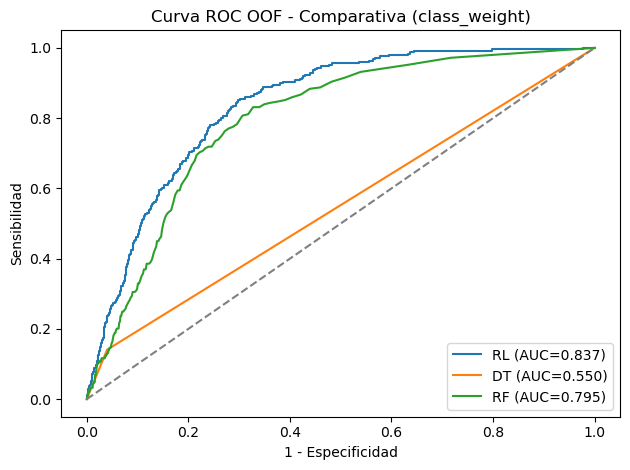

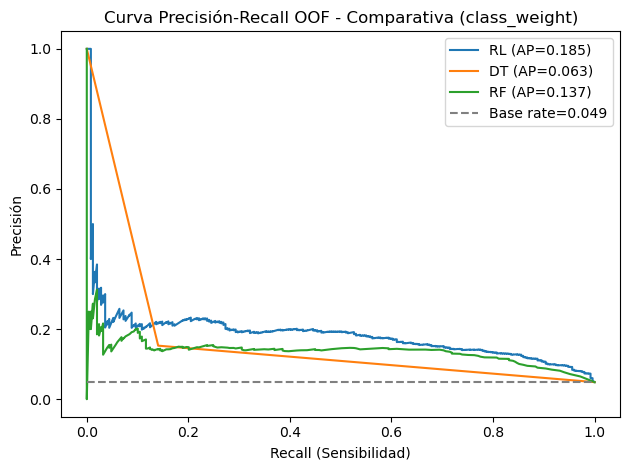

,model_name,auc,thr_opt_youden,thr_opt_f1,sensitivity_t05,specificity_t05,precision_t05,f1_t05,accuracy_t05,sensitivity_tyouden,specificity_tyouden,precision_tyouden,f1_tyouden,accuracy_tyouden,sensitivity_tf1,specificity_tf1,precision_tf1,f1_tf1,accuracy_tf1
0,RL,0.8367,0.4432,0.7449,0.7952,0.7369,0.1341,0.2294,0.7397,0.8554,0.6992,0.1272,0.2214,0.7068,0.5261,0.8862,0.1915,0.2808,0.8687
1,DT,0.5503,1.0000,1.0000,0.1406,0.9601,0.1528,0.1464,0.9202,0.1406,0.9601,0.1528,0.1464,0.9202,0.1406,0.9601,0.1528,0.1464,0.9202
2,RF,0.7950,0.0320,0.0620,0.0040,0.9992,0.2000,0.0079,0.9507,0.8313,0.6725,0.1151,0.2021,0.6802,0.6948,0.7838,0.1413,0.2349,0.7795


Guardado: ..\outputs\tablas\comparativa_modelos_classweight.csv
Figuras guardadas: ..\outputs\figuras\ROC_comparativa_classweight.png | ..\outputs\figuras\PR_comparativa_classweight.png


In [7]:
# Comparar resultados

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, average_precision_score

# Cargar predicciones OOF
paths_oof = {
    "RL": TABLAS / "oof_RL_classweight.csv",
    "DT": TABLAS / "oof_DT_classweight.csv",
    "RF": TABLAS / "oof_RF_classweight.csv",
}
oof = {}
for name, p in paths_oof.items():
    dfp = pd.read_csv(p)
    assert "proba_oof" in dfp.columns and "y" in dfp.columns, f"Faltan columnas en {p}"
    oof[name] = dfp

# Verificar misma y (sanidad)
ys = [dfp["y"].values for dfp in oof.values()]
assert all((ys[0] == y_).all() for y_ in ys[1:]), "Las etiquetas y no coinciden entre archivos OOF."

y_true = oof["RL"]["y"].values

# ROC comparativa
plt.figure()
for name, dfp in oof.items():
    proba = dfp["proba_oof"].values
    auc  = roc_auc_score(y_true, proba)
    fpr, tpr, _ = roc_curve(y_true, proba)
    plt.plot(fpr, tpr, label=f"{name} (AUC={auc:.3f})")

plt.plot([0,1], [0,1], linestyle="--", color="grey")
plt.xlabel("1 - Especificidad")
plt.ylabel("Sensibilidad")
plt.title("Curva ROC OOF - Comparativa (class_weight)")
plt.legend(loc="lower right")
plt.tight_layout()
plt.savefig(FIGURAS / "ROC_comparativa_classweight.png", dpi=300)
plt.show()

# PR comparativa
baseline = y_true.mean()  # prevalencia positiva
plt.figure()
for name, dfp in oof.items():
    proba = dfp["proba_oof"].values
    prec, rec, _ = precision_recall_curve(y_true, proba)
    ap = average_precision_score(y_true, proba)
    plt.plot(rec, prec, label=f"{name} (AP={ap:.3f})")

plt.hlines(baseline, 0, 1, colors="grey", linestyles="--", label=f"Base rate={baseline:.3f}")
plt.xlabel("Recall (Sensibilidad)")
plt.ylabel("Precisión")
plt.title("Curva Precisión-Recall OOF - Comparativa (class_weight)")
plt.legend(loc="upper right")
plt.tight_layout()
plt.savefig(FIGURAS / "PR_comparativa_classweight.png", dpi=300)
plt.show()

# Tabla comparativa
paths_res = {
    "RL": TABLAS / "resultados_RL_classweight_cv.csv",
    "DT": TABLAS / "resultados_DT_classweight_cv.csv",
    "RF": TABLAS / "resultados_RF_classweight_cv.csv",
}
frames = []
for name, p in paths_res.items():
    dfres = pd.read_csv(p)
    dfres.insert(0, "model_name", name)
    frames.append(dfres)

comparativa = pd.concat(frames, ignore_index=True)

# Seleccionar columnas clave
cols_show = [
    "model_name", "auc",
    "thr_opt_youden", "thr_opt_f1",
    "sensitivity_t05","specificity_t05","precision_t05","f1_t05","accuracy_t05",
    "sensitivity_tyouden","specificity_tyouden","precision_tyouden","f1_tyouden","accuracy_tyouden",
    "sensitivity_tf1","specificity_tf1","precision_tf1","f1_tf1","accuracy_tf1",
]
# Filtrar columnas que existan
cols_show = [c for c in cols_show if c in comparativa.columns]
comparativa = comparativa[cols_show].copy()

# Guardar tabla comparativa
out_comp = TABLAS / "comparativa_modelos_classweight.csv"
comparativa.round(4).to_csv(out_comp, index=False)
display(comparativa.round(4))
print("Guardado:", out_comp)
print("Figuras guardadas:",
      FIGURAS / "ROC_comparativa_classweight.png",
      "|",
      FIGURAS / "PR_comparativa_classweight.png")